### Model 4

Based on VGG16 Architecture

Finally, just for experimental purposes, we train the VGG16 full architecture with our dataset to see if there are any improvement in validation accuracy and validation loss.

In [1]:
%matplotlib inline
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Dimension for our images
img_width, img_height = 150, 150

# Directories containing image
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

In [3]:
import os

nor_train_dir = 'data/train/normal/'
nor_valid_dir = 'data/validation/normal/'
abnor_train_dir = 'data/train/abnormal/'
abnor_valid_dir = 'data/validation/abnormal/'

nor_train = len(next(os.walk(nor_train_dir))[2])
nor_valid = len(next(os.walk(nor_valid_dir))[2])
abnor_train = len(next(os.walk(abnor_train_dir))[2])
abnor_valid = len(next(os.walk(abnor_valid_dir))[2])

## We subtract 1 since every directory has a hidden file .DS_Store
print ('Number of samples in training set (normal): {}'.format((nor_train)-1))
print ('Number of samples in validation set (normal): {}'.format((nor_valid)-1))
print ('Number of samples in training set (abnormal): {}'.format((abnor_train)-1))
print ('Number of samples in validation set (abnormal): {}'.format((abnor_valid)-1))

Number of samples in training set (normal): 599
Number of samples in validation set (normal): 142
Number of samples in training set (abnormal): 399
Number of samples in validation set (abnormal): 81


In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        )

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=4,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=4,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 225 images belonging to 2 classes.


In [6]:
import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [7]:
import matplotlib.pyplot as plt
def results(history):
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()

In [8]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(img_width,img_height,3)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
#model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  """
C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if __name__ == '__main__':
C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activ

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
nb_epoch =3
nb_train_samples = 1000
nb_validation_samples = 225

In [11]:
history = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=250, epochs=3, validation_steps=225)`
  



Epoch 1/3
250/250 [==============================] - 43s 171ms/step - loss: 0.6849 - accuracy: 0.5940 - precision: 0.5830 - recall: 0.9480 - fbeta_score: 0.6968 - val_loss: 0.7081 - val_accuracy: 0.6330 - val_precision: 0.6300 - val_recall: 0.9689 - val_fbeta_score: 0.7366
Epoch 2/3
250/250 [==============================] - 39s 157ms/step - loss: 0.6753 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.9560 - fbeta_score: 0.7102 - val_loss: 0.6493 - val_accuracy: 0.6374 - val_precision: 0.6389 - val_recall: 0.9689 - val_fbeta_score: 0.7482
Epoch 3/3
250/250 [==============================] - 39s 157ms/step - loss: 0.6769 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.9760 - fbeta_score: 0.7198 - val_loss: 0.5532 - val_accuracy: 0.6318 - val_precision: 0.6367 - val_recall: 0.9867 - val_fbeta_score: 0.7500


In [12]:
model.evaluate_generator(validation_generator, nb_validation_samples) ## [Loss,
                                                                      ##  Accuracy,
                                                                      ##  Precision,
                                                                      ##  Recall
                                                                      ##  F-BetaScore]

[0.7045629024505615,
 0.6318743228912354,
 0.6322222352027893,
 0.9688888788223267,
 0.741037130355835]

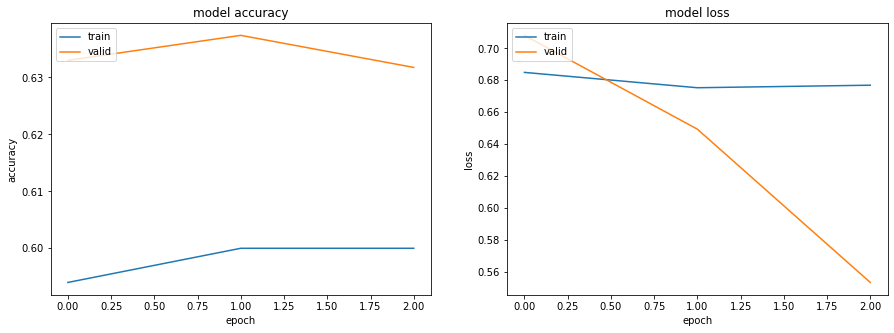

In [13]:
results(history)